<a href="https://colab.research.google.com/github/yuxuan0702/Twitter-data-Analysis/blob/master/network_and_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# basic analysis packages 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

# network analysis packages 
import networkx as nx 

# text mining analysis packages 
import nltk
import gensim
from nltk.corpus import stopwords
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Social Network Analysis 

In [0]:
# import extract data 
df=pd.read_csv('/content/drive/My Drive/第四个学期/MA710/social network/network.csv')
df.head()

,ID,from,to,Value
0,1,unfoxmycablebox,tile,1
1,2,MSNBC,tile,1
2,3,chrislhayes,tile,1
3,4,blue_mitchell22,tile,1
4,5,MikeBloomberg,tile,1


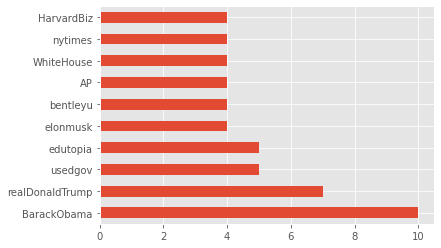

In [0]:
#most following person 
plt.style.use('ggplot')
df['from'].value_counts().head(10).plot(kind='barh')

In [0]:
# construct network object 
G = nx.from_pandas_edgelist(df,'to','from')

In [0]:
# calculate max degree node 
degree = nx.degree_centrality(G)
print(max(degree.keys(), key=lambda x:degree[x]))

MarkBallardCnb


In [0]:
degree['MarkBallardCnb']

0.09016018306636156

In [0]:
# calculate max closeness node 
Closeness = nx.closeness_centrality(G)
print(max(Closeness.keys(), key=lambda x:Closeness[x]))

BarackObama


In [0]:
Closeness['BarackObama']

0.3394467647893551

In [0]:
# calculate max betweeness centrality 
between = nx.betweenness_centrality(G)
print(max(between.keys(), key=lambda x:between[x]))

BarackObama


In [0]:
print(max(between.keys(), key=lambda x:between[x]))

BarackObama


In [0]:
# calculate max eigenvector centrality 
eigen = nx.eigenvector_centrality(G, tol=1e-2)
print(max(eigen.keys(), key=lambda x:eigen[x]))

MarkBallardCnb


In [0]:
eigen['MarkBallardCnb']

0.36432790552194133

# Text Analysis 

In [0]:
# import dataset 
df = pd.read_csv('/content/drive/My Drive/第四个学期/MA710/social network/data.csv',index_col=[0])
df.head()

,username,tweet,time,retweet,fav
0,tile,What about the Bentley Continental GT that eve...,2020-04-24 17:34:29+00:00,0,0
1,Bentley_CMT,Help Bentley students raise money for the Bent...,2020-04-24 15:42:59+00:00,0,0
2,CoBrevard,Bentley Institute Announces Digital Infrastruc...,2020-04-24 04:01:32+00:00,0,0
3,directionsmag,"""Bentley Institute announces “Digital Infrastr...",2020-04-23 16:12:27+00:00,0,0
4,AlanCowgill,https://bit.ly/MarcoDeals Well over a decade a...,2020-04-23 01:47:33+00:00,0,0


## General Analysis 

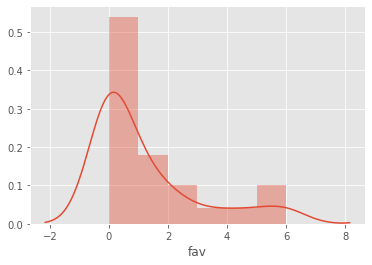

In [0]:
sns.distplot(df['fav'])

In [0]:
# convert to datetime 
df['time']=pd.to_datetime(df['time'])
df['time']=df['time'].dt.date

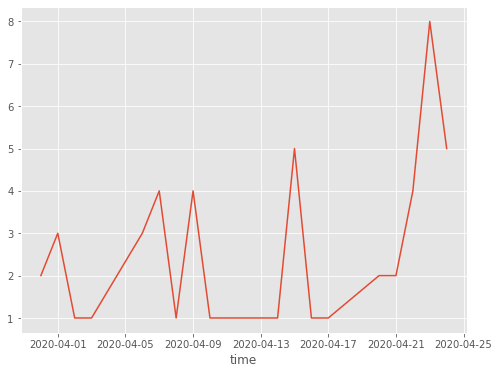

In [0]:
# time distribution 
plt.figure(figsize=(8,6))
df.groupby('time')['username'].count().plot()

## Word Frequency 

In [0]:
# extract tweet
tweet=list(df['tweet'])
string = ",".join(tweet)
string

'What about the Bentley Continental GT that every student athlete got too? Some of them got beachfront homes too!!! Why focus on crappy headphones? Aim high and grab the brass ring with your stories man!,Help Bentley students raise money for the Bentley Emergency Assistance Fund (EAF) to help out students in dire financial straits. Visit and share their online pop-up store at https://keep-the-beat-going.myshopify.com Hurry the store closes on April 29th! #keetthebeatgoing #bentleyuniversity,Bentley Institute Announces Digital Infrastructure Student Challenge https://ift.tt/3cJuyQl #roofing #florida #brevardcounty,"Bentley Institute announces “Digital Infrastructure Student Idea Challenge 2020”" https://www.directionsmag.com/pressrelease/9744 #GIS,https://bit.ly/MarcoDeals Well over a decade ago I met a guy named Marco. I met his family. His children are named Bentley and Mercedes, which I found memorable I have watched him travel all over the world helping his students-teaches how to d

In [0]:
# remove stop words and token 
clean_text=remove_stopwords(string)
token=nltk.word_tokenize(clean_text)

In [0]:
# stem word 
ps = PorterStemmer() 
stem_word = []
for w in token: 
  stem_word.append(ps.stem(w))

In [0]:
# freq dist 
freq=FreqDist(stem_word)
data_freq = pd.DataFrame([freq.keys(),freq.values()]).transpose()
data_freq.columns=['word','freq']
data_freq.sort_values('freq',ascending=False,inplace=True)
data_freq['len']=data_freq['word'].apply(len)

In [0]:
# choose meaningful words 
data_freq = data_freq[data_freq['len']>1]

In [0]:
# glance at data freq 
pd.set_option("display.max_rows",500)
data_freq

,word,freq,len
1,bentley,55,7
4,student,50,7
43,http,11,4
226,'s,7,2
168,year,7,4
...,...,...,...
282,let,1,3
278,deserv,1,6
276,acc…,1,4
275,target,1,6


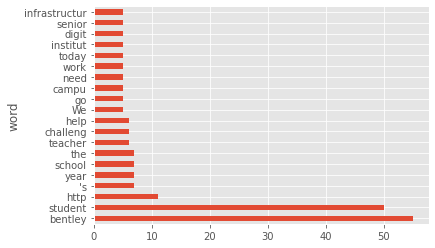

In [0]:
# visualize the result 
plt.style.use('ggplot')
data_freq.set_index('word',drop=True).head(20)['freq'].plot(kind='barh')

## Extract Topic 

In [0]:
#prepare data 
preprocessor = TfidfVectorizer()
preprocessedText = preprocessor.fit_transform(df['tweet'])

In [0]:
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(preprocessedText, documents_columns=False)

In [0]:
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in preprocessor.vocabulary_.items())

In [0]:
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=id_map, num_topics=3, passes=25)

In [0]:
# Extract Topic Review 
ldamodel.print_topics(num_topics=10, num_words=10)

[(0,
  '0.005*"digital" + 0.005*"infrastructure" + 0.005*"institute" + 0.005*"challenge" + 0.005*"idea" + 0.005*"bentley" + 0.005*"2020" + 0.004*"student" + 0.004*"the" + 0.004*"https"'),
 (1,
  '0.004*"the" + 0.004*"and" + 0.004*"to" + 0.004*"bentley" + 0.004*"student" + 0.004*"of" + 0.003*"at" + 0.003*"is" + 0.003*"for" + 0.003*"he"'),
 (2,
  '0.005*"the" + 0.005*"students" + 0.005*"to" + 0.004*"support" + 0.004*"bentley" + 0.004*"our" + 0.004*"on" + 0.003*"for" + 0.003*"you" + 0.003*"their"')]

## Sentiment Analysis 

In [0]:
# sentiment analysis 
polarity = []
subjective = []
for i in range (0,50,1):
  blob = TextBlob(df['tweet'][i])
  polarity.append(blob.sentiment.polarity)
  subjective.append(blob.sentiment.subjectivity)

In [0]:
df['polarity'] = polarity
df['subjective'] = subjective
df.head()

,username,tweet,time,retweet,fav,polarity,subjective
0,tile,What about the Bentley Continental GT that eve...,2020-04-24,0,0,0.20,0.54
1,Bentley_CMT,Help Bentley students raise money for the Bent...,2020-04-24,0,0,0.00,0.00
2,CoBrevard,Bentley Institute Announces Digital Infrastruc...,2020-04-24,0,0,0.00,0.00
3,directionsmag,"""Bentley Institute announces “Digital Infrastr...",2020-04-23,0,0,0.00,0.00
4,AlanCowgill,https://bit.ly/MarcoDeals Well over a decade a...,2020-04-23,0,0,0.25,0.55


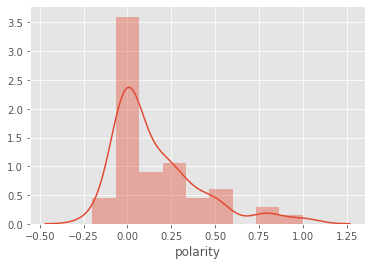

In [0]:
# we use 0 and 0.5 as cutoff 
# less than 0 should be negative 
# large than 0.5 should be postitive 
# betweeen 0 and 0.5 can be netural 
sns.distplot(df['polarity'])
bins = [float('-inf'),0,0.5,float('inf')]
df['polarity_class']=pd.cut(df['polarity'],bins = bins, labels=['negative','netural','positive'])

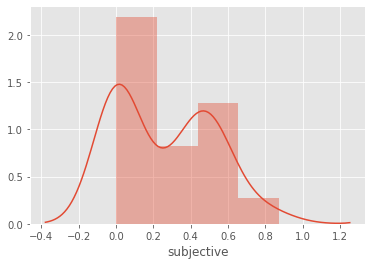

In [0]:
# we can use 0.5 as cutoff 
# large the 0.5 can be identified as subjective 
# less than 0.5 can be viewed as objective 
sns.distplot(df['subjective'])
df['subject_class']=pd.cut(df['subjective'],bins = 2, labels=['objective','subjective'])

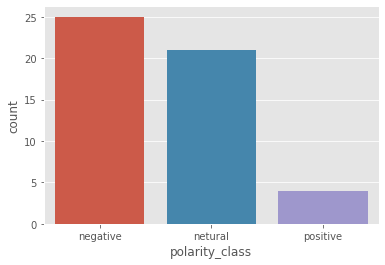

In [0]:
# visualize polarity class 
sns.countplot(df['polarity_class'])

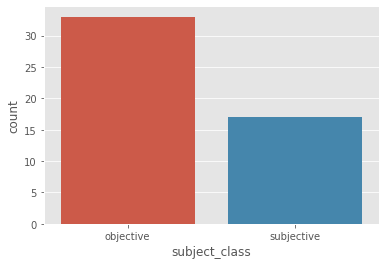

In [0]:
sns.countplot(df['subject_class'])

In [0]:
# take a view at negative class 
negative = df[df['polarity_class']=='negative'][['tweet','subject_class']]
negative

,tweet,subject_class
1,Help Bentley students raise money for the Bent...,objective
2,Bentley Institute Announces Digital Infrastruc...,objective
3,"""Bentley Institute announces “Digital Infrastr...",objective
6,HS Students: Mrs. Bentley sent out an email to...,objective
9,Support Bentley Students!,objective
10,Just got a pang of nostalgia from the Millbroo...,objective
12,"Poor kids, minorities and illegals get school ...",objective
13,"In between classes, our teachers across Bentle...",objective
14,"Erin Bentley, a UW second-year master’s studen...",objective
16,And I deserve a Bentley and not paying student...,objective


In [0]:
# extract tweet
tweet=list(negative['tweet'])
string = ",".join(tweet)
string

'Help Bentley students raise money for the Bentley Emergency Assistance Fund (EAF) to help out students in dire financial straits. Visit and share their online pop-up store at https://keep-the-beat-going.myshopify.com Hurry the store closes on April 29th! #keetthebeatgoing #bentleyuniversity,Bentley Institute Announces Digital Infrastructure Student Challenge https://ift.tt/3cJuyQl #roofing #florida #brevardcounty,"Bentley Institute announces “Digital Infrastructure Student Idea Challenge 2020”" https://www.directionsmag.com/pressrelease/9744 #GIS,HS Students: Mrs. Bentley sent out an email today with a Husker Check In form. Please take a few minutes to complete the form. Link is also here: ,Support Bentley Students! ,Just got a pang of nostalgia from the Millbrook Bentley story - I briefly worked there on placement. I was asked to take 3 students interviewing for next years\' intake on a track tour after the assessment. 1/2,Poor kids, minorities and illegals get school paid for, the C

In [0]:
# remove stop words and token 
clean_text=remove_stopwords(string)
token=nltk.word_tokenize(clean_text)

In [0]:
# stem word 
ps = PorterStemmer() 
stem_word = []
for w in token: 
  stem_word.append(ps.stem(w))

In [0]:
# freq dist 
freq=FreqDist(stem_word)
data_freq = pd.DataFrame([freq.keys(),freq.values()]).transpose()
data_freq.columns=['word','freq']
data_freq.sort_values('freq',ascending=False,inplace=True)
data_freq['len']=data_freq['word'].apply(len)

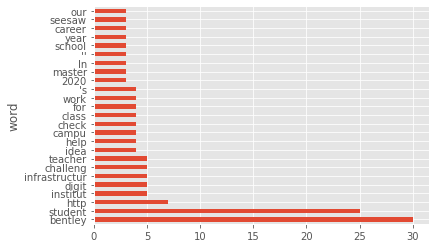

In [0]:
# choose meaningful words 
data_freq = data_freq[data_freq['len']>1]
data_freq.set_index('word',drop=True).head(25)['freq'].plot(kind='barh')